In [349]:
from pandas import Series
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve

In [350]:
train = pd.read_csv("/content/train.csv", encoding = 'ISO-8859-1', low_memory = False)


In [351]:
# Look at the dataframe
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

In [352]:
# There is only one column with missing data (less than 1%). Let's look at structure of data 
train.education.value_counts()

SCH    38860
GRD    23365
UGR     9816
PGR     1257
ACD      194
Name: education, dtype: int64

In [353]:
# And fill missing data with most popular value
train.education.fillna('SCH', inplace=True)

In [354]:
# Now we will divide columns by type
num_cols = ['age','income', 'bki_request_cnt', 'decline_app_cnt', 'score_bki']
cat_cols = ['client_id', 'education', 'home_address', 'work_address', 'region_rating', 'sna', 'first_time', 'app_date']
bin_cols = ['sex', 'car', 'car_type','good_work', 'foreign_passport']

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


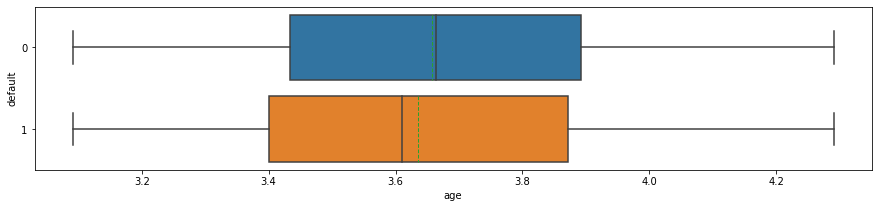

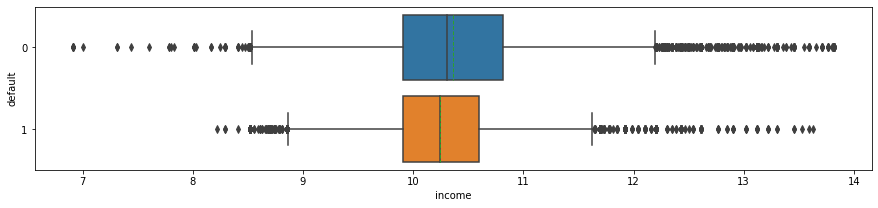

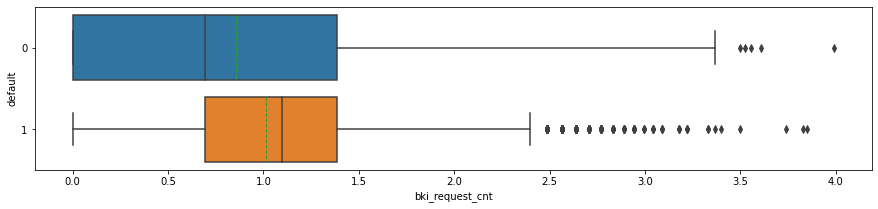

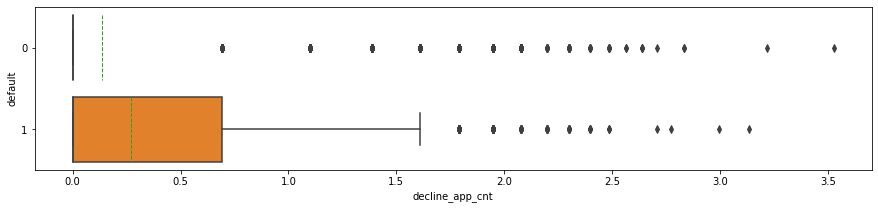

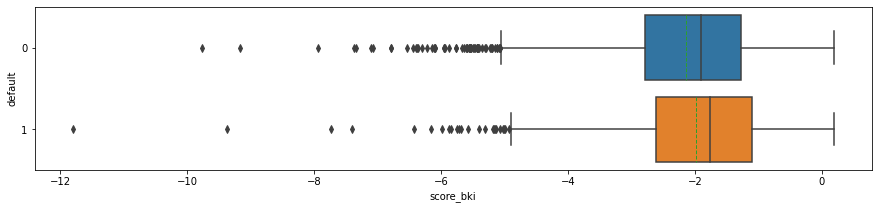

In [355]:
# Let's search for outliers in num columns by looking at boxplots
for col in num_cols:
    plt.figure(figsize=(15, 3))
    sns.boxplot(y=train.default, x=np.log(train[col]+1),
            showmeans=True, meanline=True, orient='h')

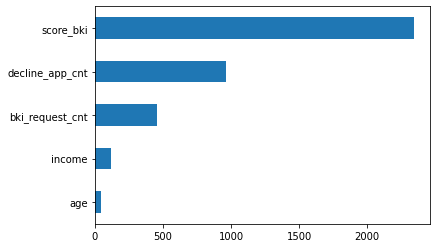

In [356]:
# The most important num params 
imp_num = pd.Series(f_classif(train[num_cols], train['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

In [357]:
# Now encoding education values
education_dict = {'SCH': 0, 'UGR': 1, 'GRD': 2, 'PGR': 4, 'ACD': 5}
train.education = train.education.replace(education_dict)

In [358]:
# Let's encode data in every binary column
label_encoder = LabelEncoder()

for column in bin_cols:
    train[column] = label_encoder.fit_transform(train[column])

In [359]:
# Let's encode app_date transformed it into timestamp
def formatDate(d):
  from datetime import datetime
  d = datetime.strptime(d, '%d-%m-%Y')
  return datetime.timestamp(d)

train.app_date.replace({'JAN':'-01-', 'FEB':'-02-', 'MAR':'-03-', 'APR':'-04-', 'MAY':'-05-', 'JUN':'-06-', 'JUL':'-07-', 'AUG':'-08-',
                        'SEP':'-09-', 'OCT':'-10-', 'NOV':'-11-', 'DEC':'-12-',}, regex=True, inplace=True)
train.app_date = train.app_date.apply(lambda x: formatDate(x))

In [360]:
train.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,1.391213e+09,0,1,62,1,1,0,0,-2.008753,1,50,1,2,18000,4,1,0,0
1,63161,1.394582e+09,0,0,59,0,0,0,0,-1.532276,3,50,2,3,19000,4,1,0,0
2,25887,1.391213e+09,0,1,25,1,0,2,0,-1.408142,1,80,1,2,30000,1,4,1,0
3,16222,1.390435e+09,0,0,53,0,0,0,0,-2.057471,2,50,2,3,10000,1,3,0,0
4,101655,1.397779e+09,2,1,48,0,0,0,1,-1.244723,1,60,2,3,30000,1,4,1,0


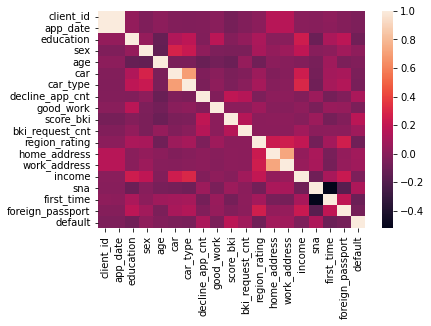

In [361]:
# Now we will look at correlation matrix
# and find four pairs highly correlated params
# So. We can remove one of each pair
sns.heatmap(train.corr())

In [362]:
train.drop(['client_id', 'car_type', 'home_address'], axis=1, inplace=True) #, 'first_time'
removed_cols = ['home_address', 'client_id'] #, 'first_time'
for column in removed_cols:
  cat_cols.remove(column)
bin_cols.remove('car_type')

In [363]:
# Now we normalize num columns
for column in num_cols:
    train[column] = (train[column] - train[column].min())/(train[column].max() - train[column].min())

In [364]:
# There are too many samples with default 0. Let's take equal parts with o and 1 from original dataset
train1 = train[train.default == 1.0]
train0 = train[train.default == 0.0].head(train1.shape[0])
train = pd.concat([train0, train1])

In [365]:
# Encode categorical columns
X_cat = OneHotEncoder(sparse = False).fit_transform(train[cat_cols].values)

In [366]:
X = np.hstack([train[num_cols], train[bin_cols].values, X_cat])
Y = train['default'].values

In [367]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=5)

In [368]:
mod = LogisticRegression(C=1, penalty='l1', max_iter=10000, solver='liblinear', tol=0.0001)
mod.fit(X_train, y_train)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

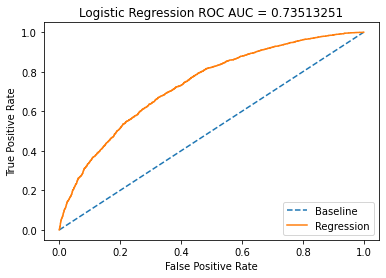

In [369]:
probs = mod.predict_proba(X_test)
probs = probs[:,1]


fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.8f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

In [370]:
y_pred = mod.predict(X_test)

In [371]:
# from sklearn.model_selection import GridSearchCV

# # Добавим типы регуляризации
# penalty = ['l1', 'l2']

# # Зададим ограничения для параметра регуляризации
# C = np.logspace(1, 4, 10)

# # Создадим гиперпараметры
# hyperparameters = dict(C=C, penalty=penalty)

# model = LogisticRegression(max_iter=10000, solver='liblinear')
# model.fit(X_train, y_train)

# # Создаем сетку поиска с использованием 5-кратной перекрестной проверки
# clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)

# best_model = clf.fit(X_train, y_train)

# # View best hyperparameters
# print('Лучшее Penalty:', best_model.best_estimator_.get_params()['penalty'])
# print('Лучшее C:', best_model.best_estimator_.get_params()['C'])